# Practical work on graph-cut optimization (part 2, multilevel)

The objective of this PW is the implementation of the $\alpha$-expansion and $\alpha$-$\beta$ swap approaches for grayscale image denoising.

The PyMaxFlow library is used to compute the graph-cut.

In [1]:
import math
import random
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt

import platform
import tempfile
import os
from scipy import ndimage as ndi
try:
    import maxflow
except:
    !pip install PyMaxflow==1.2.13
    import maxflow

from skimage import io
from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.io import output_notebook
output_notebook()

def affiche_pour_colab(im,MINI=None, MAXI=None,titre=''): #special colab, don't look
  def normalise_image_pour_bokeh(X,MINI,MAXI):
    if MAXI==None:
      MAXI = np.max(X)
    if MINI==None:
      MINI = np.min(X)
    imt=np.copy(X.copy())
    imt=(np.clip(imt,MINI,MAXI)/(MAXI-MINI))
    imt[imt<0]=0
    imt[imt>1]=1
    imt*=255
    sortie=np.empty((*imt.shape,4),dtype=np.uint8)
    for k in range(3):
      sortie[:,:,k]=imt
    sortie[:,:,3]=255
    return sortie

  img = im
  img=normalise_image_pour_bokeh(np.flipud(im),MINI,MAXI)
  p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], y_range=[im.shape[0], 0], x_range=[0, im.shape[1]], title=titre)
  # p.x_range.range_padding = p.y_range.range_padding = 0
  # must give a vector of images
  p.image(image=[im], x=0, y=0, dw=im.shape[1], dh=im.shape[0], palette="Greys9", level="image")
  p.xgrid.visible = False
  p.ygrid.visible = False
  showbokeh(p)

def affiche(im,MINI=0.0, MAXI=None,titre='',printname=False):
  affiche_pour_colab(im,MINI=MINI, MAXI=MAXI,titre=titre) # under google colab many options disappear

def display_segmentation_borders(image, bin):
    imagergb = np.copy(image)
    from skimage.morphology import binary_dilation, disk
    contour = binary_dilation(bin,disk(15))^bin
    imagergb[contour==1,0] = 255
    imagergb[contour==1,1] = 0
    imagergb[contour==1,2] = 0
    return imagergb

Loading BokehJS ...

## 2 Denoising a grayscale image


In this second part of the PW, we are interested in using Markovian methods to **denoise** images with different regularization potentials.

We are interested in denoising the images *Ibruitee.png* and *Ibruitee2.png* which correspond to the same scene perturbed by two noises of different nature.


We will complete programs that call the algorithm of alpha-expansions or Boykov's alpha-beta swap according to the Kolmogorov technique.


Q1: What are the respective expressions for the data attachment potentials in the case of noise following a Gaussian distribution (equation 1) and a Rayleigh distribution (equation 2)?

\begin{equation}
p(y_p|x_p)=\frac{1}{\sqrt{2\pi}\sigma}\exp\left[-\frac{(y_p-x_p)^2}{2\sigma^2}\right],
\end{equation}

\begin{equation}
p(y_p|x_p)=2\frac{y_p}{x_p^2}\exp\left[-\frac{y_p^2}{x_p^2}\right].
\end{equation}

**Your answer &#x270D;**

A1: $D(x_p, y_p)= ln(p(y_p|x_p))$, and we dont consider the constant terms.
- In The Gaussian distribution : $$\boxed{\textcolor{orange}{D(x_p, y_p)={(y_p-x_p)^2}}}$$
- In The Rayleigh distribution : $$\boxed{\textcolor{orange}{D(x_p, y_p)={\frac{y_p^2}{x_p^2} + ln(y_p) - 2ln(x_p)}}}$$

Q2: By studying the histogram of a homogeneous area, indicate which type of noise is present in which image.  



**Your answer &#x270D;**

A2:

In [12]:
im_obs=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee.png') # Observed image, noisy
im_obs2=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee2.png') # Observed image, noisy
im_orig=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/IoriginaleBW.png') # Reference binary image, to evaluate the quality of the segmentation

I = im_obs
affiche(im_obs,MINI=0.0, MAXI=255.,titre="Noisy image",printname=True)
affiche(im_obs2,MINI=0.0, MAXI=255.,titre="Noisy image",printname=True)

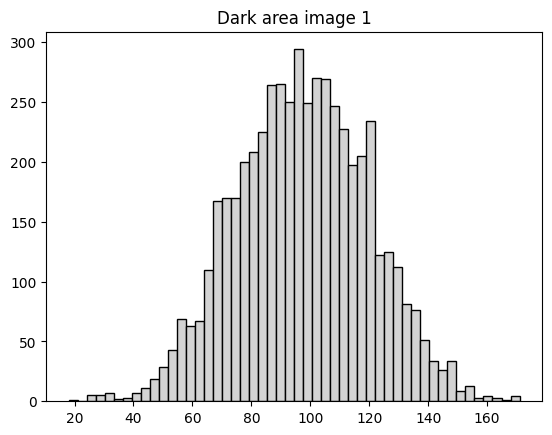

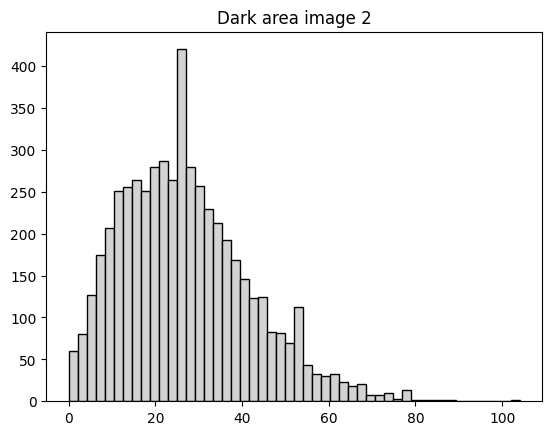

In [13]:
# select a homogeneous area to study the histogram
# we can use the area from 45 to 120 and from 175 to 245
affiche(im_obs[45:120,175:245],MINI=0.0, MAXI=255.,titre="Noisy image",printname=True)

plt.figure()
plt.hist(im_obs[45:120,175:245].flatten(),50,color='lightgray', edgecolor='black')
plt.title('Dark area image 1')
plt.show()

plt.figure()
plt.hist(im_obs2[45:120,175:245].flatten(),50,color='lightgray', edgecolor='black')
plt.title('Dark area image 2')
plt.show()


We will compare three *a priori* models: the Potts model $\delta_{x_p=x_q}$, the (discrete) total variation $|x_p-x_q|$, and the (quadratic) Gaussian model $(x_p-x_q)^2$.

Q3: Are they metrics or semi-metrics? What can we deduce about the optimization method to use?

**Your answer &#x270D;**

A3: 
- $V(., .)$ is a metric model when : $V(x_p, x_q) \leq V(x_p, x_s) + V(x_s, x_q) $
- Potts model is then metric

Q4: What are the differences between the alpha expansion method and the alpha-beta swap method?

**Your answer &#x270D;**

A4:

In the following sections we will use the functions aexpansion_grid and abswap_grid which perform the alpha-expansion and alpha-beta swap respectively. These functions take as input two arguments for a number of levels L :
- a tensor of the image size containing in the 3rd dimension the data attachment of each pixel for each considered level (unary term)
- a matrix containing the values of the interaction terms between two levels $l_1$ and $l_2$ (depends on the chosen interaction potential)

### 2.1 Denoising in the Gaussian case (synthetic image)

In [ ]:
from maxflow.fastmin import aexpansion_grid, abswap_grid

# Loading images
im_obs=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee.png').astype('float') # Observed image, noisy
im_obs2=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee2.png').astype('float') # Observed image, noisy
im_orig=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/IoriginaleBW.png').astype('float') # Reference binary image, to evaluate the quality of the segmentation

I = im_obs

I = I*255/I.max()
L = 30
# Generates L gray levels for nearsest prototype labeling
levs = np.arange(0, 255, 255/L)
# Calculate data cost as the absolute difference between the label prototype and the pixel value
D = np.double(np.abs((I.reshape(I.shape+(1,)) - levs.reshape((1,1,-1)))**2))

affiche(I,MINI=0.0, MAXI=255.,titre="Noisy image",printname=True)

# Generate nearest prototype labeling
Id = np.argmin(D,2)
affiche(Id*255/L,MINI=0.0, MAXI=255.,titre="Maximum likelihood denoising",printname=True)
print(D.shape)


Q5: Here, what does the array D correspond to? Explain its dimension.

**Your answer &#x270D;**

A5:

Complete the programs below, and test each regularization model by determining an appropriate beta value each time.

In [ ]:
# Potts model regularization
# beta values of several hundred
beta_Potts =
# definition of the regularization matrix V(i,j) for the Potts model
V_Potts = np.double(beta_Potts*(np.abs( levs.reshape((-1,1)) - levs.reshape((1,-1)))>0))
affiche(V_Potts)

# Performs the alpha-expansion based on the data attachment D and the regularization V
labels_Potts = aexpansion_grid(D,V_Potts)
affiche(labels_Potts*255/L,MINI=0.0, MAXI=255.0,titre="Graph Cut Denoising, Potts regularization, beta = " + str(beta_Potts),printname=True)

In [ ]:
# TV model regularization
# beta value of the order of tens
beta_TV =
# definition of the regularization matrix V(i,j) for the TV model
V_TV =
affiche(V_TV)

# Performs the alpha-expansion based on the data attachment D and the regularization V
labels_TV =
print("Calcul TV terminé")
affiche(labels_TV*255/L,MINI=0.0, MAXI=255.0,titre="Graph Cut Denoising, TV regularization, beta = " + str(beta_TV),printname=True)

In [ ]:
# Quadratic model regularization
# beta value of the order of tens
beta_quadratic =
# definition of the regularization matrix V(i,j) for the quadratic model
V_quadratic =
affiche(V_quadratic)

# Performs the alpha-beta swap based on the data attachment D and the regularization V
labels_Quadratic =
affiche(labels_Quadratic*255/L,MINI=0.0, MAXI=255,titre="Graph Cut Denoising, TV regularization, beta = " + str(beta_quadratic),printname=True)

Q6: Which regularization model do you think is best? Give the best regularization parameter visually found and comment on the results you get in each of the three cases.

**Your answer &#x270D;**

A6:

### 2.2 Denoising in the case of speckle noise (synthetic image)

Modify the following cells to fit the model for denoising the im_obs2 image.

Q7: Which modifications are needed? (There are several!)

**Your answer &#x270D;**

A7:

In [ ]:
from maxflow.fastmin import aexpansion_grid
from numpy import log

# Loading image
im_obs2=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee2.png').astype('float') # Observed image, noisy
I = im_obs2
I = I*255/I.max()
affiche(I,MINI=0.0, MAXI=255.,titre="Noisy image 2",printname=True)

L = 30
# Generates L gray levels for nearsest prototype labeling
levs = np.arange(1/L, 255, 255/L)

# Calculate data cost as the absolute difference between the label prototype and the pixel value
D = -log(2*I.reshape(I.shape+(1,))/levs.reshape((1,1,-1))**2)+(I.reshape(I.shape+(1,))**2/levs.reshape((1,1,-1))**2)
print()
Id = np.argmin(D,2)

# Generate nearest prototype labeling
Id = np.argmin(D,2)
affiche(Id/L*255,MINI=0.0, MAXI=255.,titre="Maximum likelihood denoising",printname=True)

In [ ]:
# beta value in the order of tenths of a unit
beta_Potts =
# definition of the Potts potential matrix
V_Potts =

# Performs the alpha-expansion based on the data attachment D and the regularization V
labels_Potts =
affiche(labels_Potts*255/L,MINI=0.0, MAXI=255,titre="Graph Cut Denoising, Potts regularization, beta = " + str(beta_Potts),printname=True)

In [ ]:
# beta value in hundredths of a unit
beta_TV =
# definition of the regularization matrix for TV
V_TV =

# Performs the alpha-expansion based on the data attachment D and the regularization V
labels_TV =
print("TV computation completed")
affiche(labels_TV*255/L,MINI=0.0, MAXI=255,titre="Graph Cut Denoising, TV regularization, beta = " + str(beta_TV),printname=True)

In [ ]:
# beta value in the order of thousandths of a unit
beta_quadratic =
# definition of the regularization matrix for a quadratic potential
V_quadratic =

# Performs the alpha-expansion based on the data attachment D and the regularization V
labels_Quadratic =
affiche(labels_Quadratic*255/L,MINI=0.0, MAXI=255.,titre="Graph Cut Denoising, Quadratic regularization, beta = " + str(beta_quadratic),printname=True)

### 2.3 Denoising a natural image

Apply one of the methods used above to denoise the noisy cameraman image. Justify your choice.

Q8: Comment on the result obtained.

**Your answer &#x270D;**

A8:

In [ ]:
from skimage.color import rgb2gray
import imageio.v2 as imageio

I_cameraman = imageio.imread('https://people.math.sc.edu/Burkardt/data/tif/cameraman.tif')
I_cameraman_bruit = I_cameraman + np.random.normal(0,80,I_cameraman.shape)
I_cameraman_bruit[I_cameraman_bruit<0] = 0
I_cameraman_bruit[I_cameraman_bruit>255] = 255
print(I_cameraman.max())

plt.figure(figsize=(7,7))
plt.imshow(I_cameraman, cmap='gray')
plt.title('Image without noise')
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(I_cameraman_bruit, cmap='gray')
plt.title('Noisy image')
plt.show()

In [ ]:
I = 255*I_cameraman_bruit/I.max()
L = 250
# Generates L gray levels for nearsest prototype labeling
levs =
# Calculate data cost as the absolute difference between the label prototype and the pixel value
D =

# choose a regularization model and compute V matrix

# compute the appropriate optimization

# display the regularized image

### 2.3 SAR Image Denoising

SAR (Synthetic Aperture Radar) imagery is a radar-based remote sensing modality that provides images of the Earth in all light and weather conditions. A major drawback is the high speckle noise that affects them. The following cell loads an amplitude image acquired by the Sentinel 1-A satellite over the city of Des Moines in the USA. To limit the computation time, we will work on a small rectangle from the image provided.

Adapt one of the methods used previously to denoise the image provided. We will assume that the noise follows a Rayleigh distribution.

Q9: Comment on the result obtained.

We can compare the result with a denoising obtained by a more recent method (SAR2SAR), based on a Deep Learning approach (the code to display it is provided below).

**Your answer &#x270D;**

A9:

In [ ]:
try:
    I_SAR = np.load('noisy_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1')
except:
    !wget 'https://www.dropbox.com/s/7m2dw3irho8dpzj/noisy_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1'
    I_SAR = np.load('noisy_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1')

affiche(I_SAR,0,100,'Full image')
I_SAR = I_SAR[0:300,0:300]
plt.figure(figsize=(7,7))
plt.imshow(I_SAR,vmax = 100, cmap = 'gray') # The display is done by truncating the dynamic
plt.show()

plt.figure()
plt.hist(I_SAR[100:200,100:200].flatten(),200) # Display of the histogram on an almost homogeneous area
plt.show()

In [ ]:
I = I_SAR*255/I_SAR.max()
L = 255
# Generates L gray levels for nearsest prototype labeling
levs =
# Calculate data cost as the neg-log likelihood
D =
print()
affiche(I,MINI=0.0, MAXI=100,titre="Noisy image",printname=True)

# choose a regularization model and compute V matrix

# compute the appropriate optimization

# display the regularized image


In [ ]:
# Display of the denoised image by the SAR2SAR method

try:
    I_SAR = np.load('denoised_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1')
except:
    !wget 'https://www.dropbox.com/s/0f6l0qr6teck5bd/denoised_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1'
    I_SAR = np.load('denoised_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1')

affiche(I_SAR,0,100,'Full image')
I_SAR = I_SAR[0:300,0:300]
plt.figure(figsize=(7,7))
plt.imshow(I_SAR,vmax = 100, cmap = 'gray') # The display is done by truncating the dynamic
plt.show()

plt.figure()
plt.hist(I_SAR[100:200,100:200].flatten(),200) # Display of the histogram on an almost homogeneous area
plt.show()